In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import gc
import math

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

import os

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import torch

from imblearn.over_sampling import RandomOverSampler


from torchvision.datasets.utils import download_url
import torchvision as tv
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image

In [ ]:
#train = pd.read_csv('train.csv').head(200)
data = pd.read_csv('/content/drive/MyDrive/Personal/FuseMachine/train.csv')

data

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


In [ ]:
data['label'].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [ ]:
data.dtypes

image_id    object
label        int64
dtype: object

In [ ]:
label_classes = {0:"Cassava Bacterial Blight (CBB)",
                 1:"Cassava Brown Streak Disease (CBSD)",
                 2:"Cassava Green Mottle (CGM)",
                 3:"Cassava Mosaic Disease (CMD)",
                 4:"Healthy"
                 }

In [ ]:
class_converter = {'Cassava Bacterial Blight (CBB)': 0,
                   'Cassava Mosaic Disease (CMD)': 3,
                   'Cassava Brown Streak Disease (CBSD)': 1,
                   'Cassava Green Mottle (CGM)': 2,
                   'Healthy': 4}

In [ ]:
data['class'] = data['label'].replace([0, 1, 2, 3, 4], [label_classes[0],label_classes[1],label_classes[2],label_classes[3],label_classes[4]])

In [ ]:
data

,image_id,label,class
0,1000015157.jpg,0,Cassava Bacterial Blight (CBB)
1,1000201771.jpg,3,Cassava Mosaic Disease (CMD)
2,100042118.jpg,1,Cassava Brown Streak Disease (CBSD)
3,1000723321.jpg,1,Cassava Brown Streak Disease (CBSD)
4,1000812911.jpg,3,Cassava Mosaic Disease (CMD)
...,...,...,...
21392,999068805.jpg,3,Cassava Mosaic Disease (CMD)
21393,999329392.jpg,3,Cassava Mosaic Disease (CMD)
21394,999474432.jpg,1,Cassava Brown Streak Disease (CBSD)
21395,999616605.jpg,4,Healthy


In [ ]:
TEST_DATA_DIR = '/content/drive/MyDrive/Personal/FuseMachine/test_images'
TRAIN_DATA_DIR = '/content/drive/MyDrive/Personal/FuseMachine/train_images/'

In [ ]:
os.listdir(TEST_DATA_DIR)

['2216849948.jpg']

In [ ]:
files = os.listdir(TRAIN_DATA_DIR)[:100]
files[:5]

['802266352.jpg',
 '807190211.jpg',
 '811520495.jpg',
 '795383461.jpg',
 '816404060.jpg']

In [ ]:
from torch.utils.data import Dataset, DataLoader, IterableDataset

In [ ]:
class CassavaLeafDiseaseDataset(IterableDataset):
    def __init__(self, root, files, labels, classes, transform):
        super(CassavaLeafDiseaseDataset).__init__()
        self.root = root
        self.files = files
        self.labels = labels
        self.classes = classes
        self.transform = transform
        self.start = 0
        self.end = len(files)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]
        fpath = os.path.join(self.root, fname)
        img = self.transform(Image.open(fpath).convert('RGB'))
        class_label_int = self.labels[i]
        return img, class_label_int

    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:  # single-process data loading, return the full iterator
            iter_start = self.start
            iter_end = self.end
        else:  # in a worker process
            # split workload
            per_worker = int(math.ceil((self.end - self.start) / float(worker_info.num_workers)))
            worker_id = worker_info.id
            iter_start = self.start + worker_id * per_worker
            iter_end = min(iter_start + per_worker, self.end)
        return map(self.__getitem__, range(iter_start, iter_end))

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
df = {}
train_df, test_df = train_test_split(
    data, stratify=data.label, train_size=0.8, random_state=0
)

In [ ]:
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
train_df, test_df

(             image_id  label                                class
 0       312043582.jpg      3         Cassava Mosaic Disease (CMD)
 1      3257543417.jpg      2           Cassava Green Mottle (CGM)
 2      3192892221.jpg      3         Cassava Mosaic Disease (CMD)
 3      3871723794.jpg      3         Cassava Mosaic Disease (CMD)
 4       182316349.jpg      0       Cassava Bacterial Blight (CBB)
 ...               ...    ...                                  ...
 17112  3907605648.jpg      1  Cassava Brown Streak Disease (CBSD)
 17113  1217828400.jpg      3         Cassava Mosaic Disease (CMD)
 17114  2203184461.jpg      3         Cassava Mosaic Disease (CMD)
 17115  2302473877.jpg      3         Cassava Mosaic Disease (CMD)
 17116     6788393.jpg      3         Cassava Mosaic Disease (CMD)
 
 [17117 rows x 3 columns],
             image_id  label                                class
 0     1309174561.jpg      4                              Healthy
 1      115829780.jpg      1  Cassa

In [ ]:
datasets = {}
datasets['train'] = CassavaLeafDiseaseDataset(TRAIN_DATA_DIR, train_df['image_id'].to_numpy(),
                                              train_df['label'].to_numpy(), label_classes, T.ToTensor())
datasets['test'] = CassavaLeafDiseaseDataset(TRAIN_DATA_DIR, test_df['image_id'].to_numpy(),
                                             test_df['label'].to_numpy(), label_classes, T.ToTensor())

In [ ]:
batch_size = 16
dataloaders = {}
dataloaders['train'] = DataLoader(datasets['train'], batch_size, num_workers=2, pin_memory=False, shuffle=False, drop_last=True)
dataloaders['test'] = DataLoader(datasets['test'], batch_size, num_workers=2, pin_memory=False, drop_last=True)

In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 34.2 MB/s 
     |████████████████████████████████| 182 kB 68.5 MB/s 


In [ ]:
from timm.data import create_transform


In [ ]:
def show_image(data):
    img, label = data
    plt.imshow(img.permute(1, 2, 0))
    plt.show()
    print('Label: ' + label_classes[label])

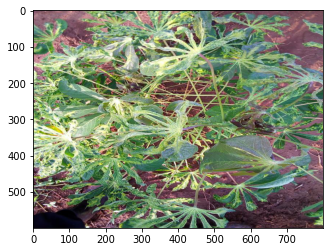

Label: Cassava Mosaic Disease (CMD)


In [ ]:
show_image(datasets['train'][3])

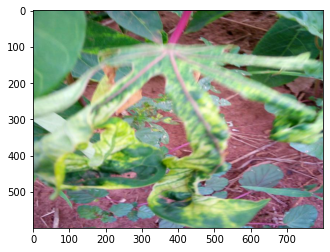

Label: Cassava Mosaic Disease (CMD)


In [ ]:
show_image(datasets['test'][3])

In [ ]:
datasets['train'].transform = create_transform(384, is_training=True)
datasets['test'].transform = T.Compose([T.Resize(size=400),
                                        T.CenterCrop(size=(384, 384)),
                                        T.ToTensor()])

In [ ]:
create_transform(384, is_training=False)

Compose(
    Resize(size=438, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(384, 384))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

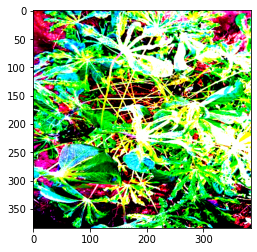

Label: Cassava Mosaic Disease (CMD)


In [ ]:
show_image(datasets['train'][3])

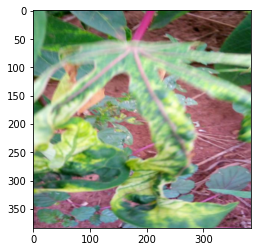

Label: Cassava Mosaic Disease (CMD)


In [ ]:
show_image(datasets['test'][3])

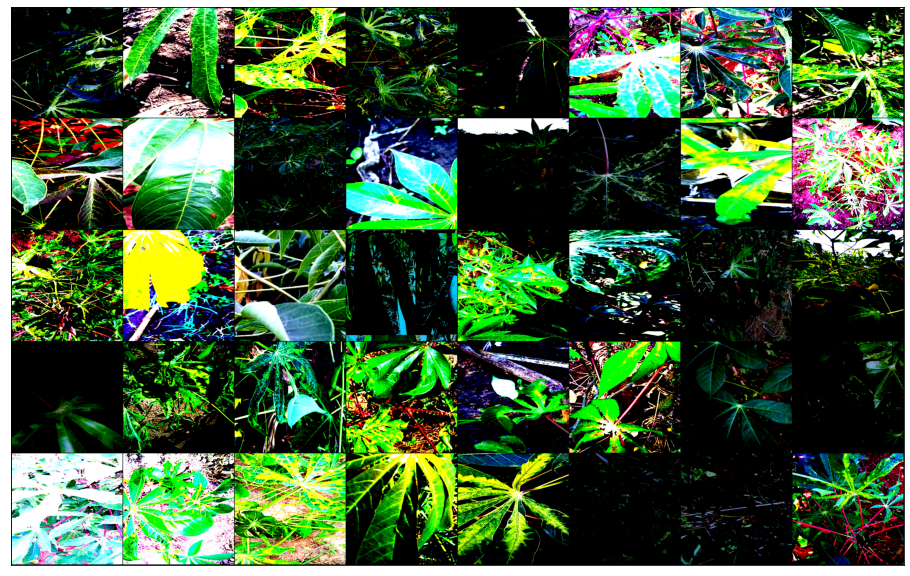

In [ ]:
from torchvision.utils import make_grid
def show_dataset(ds):
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_xticks([]); ax.set_yticks([])
    images = []
    for i in range(40):
        image, label = ds[i]
        images.append(image)
    ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))

show_dataset(datasets['train'])

In [ ]:
gc.collect()

11636

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))

        x = self.relu(self.batch_norm2(self.conv2(x)))

        x = self.conv3(x)
        x = self.batch_norm3(x)

        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)

        return x


In [ ]:

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()


        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      x = self.relu(x)
      return x




In [ ]:
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []

        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )

        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion

        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))

        return nn.Sequential(*layers)


In [ ]:
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)

def ResNet101(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,23,3], num_classes, channels)

def ResNet152(num_classes, channels=3):
    return ResNet(Bottleneck, [3,8,36,3], num_classes, channels)

In [ ]:
model_ft = ResNet50(5).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
# optimizer = torch.optim.Adam(model_ft.parameters(),lr=0.001 / 10, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

In [ ]:
# EPOCHS = 200
# for epoch in range(EPOCHS):
#     losses = []
#     running_loss = 0
#     for i, inp in enumerate(dataloaders['train']):
#         inputs, labels = inp
#         inputs, labels = inputs.to('cuda'), labels.to('cuda')
#         optimizer.zero_grad()

#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         losses.append(loss.item())

#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#         if i%100 == 0 and i > 0:
#             print(f'Loss [{epoch+1}, {i}](epoch, minibatch): ', running_loss / 100)
#             running_loss = 0.0

#     avg_loss = sum(losses)/len(losses)
#     scheduler.step(avg_loss)

# print('Training Done')

torch.Size([16, 5])


In [ ]:
def evaluate(model, dataloader):
    outputs = []
    with torch.no_grad():
        model.eval()
        for batch in dataloader:
            images, labels = batch
            images = images.to(device,non_blocking=True)
            labels = labels.to(device,non_blocking=True)
            out = model(images)
            loss = F.cross_entropy(out, labels)

            _, preds = torch.max(out, dim=1)
            acc = torch.tensor(torch.sum(preds == labels).item() / len(preds))
            outputs.append({'test_loss': loss.detach(), 'test_acc': acc})

        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        result = {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}
        torch.cuda.empty_cache()

    return result

In [ ]:
history = [evaluate(model_ft, dataloaders['test'])]
history

KeyboardInterrupt: ignored

In [ ]:
!pip install torch-lr-finder
from torch_lr_finder import LRFinder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.52E-03


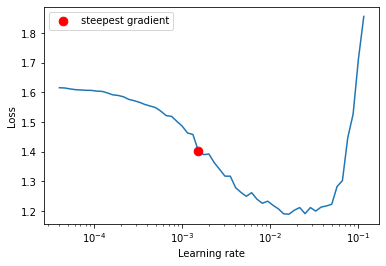

In [ ]:
lr_finder = LRFinder(model_ft, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'],start_lr = 1e-5, end_lr=10, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
gc.collect()

93

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def train_fine_tuning(epochs, lr, model, train_loader, test_loader, weight_decay,
                      devices,accum_iter, print_every, optimizer=torch.optim.Adam):

    optimizer = optimizer(model.parameters(),
                          lr=lr / 10, weight_decay=weight_decay)

    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

    total_hist = [[],[],[],[]]

    # batch accumulation parameter
    accum_iter = accum_iter

    steps = 0
    running_loss = 0
    running_accuracy = 0
    print_every = print_every

    for epoch in range(epochs):

        model.train()

        for batch_idx, (images, labels) in enumerate(train_loader):
            steps += 1

            images,labels = images.to(device),labels.to(device)

            with torch.set_grad_enabled(True):

                y_hat = model(images)
                loss = criterion(y_hat, labels)

                running_loss += loss.item()

                ps = torch.exp(y_hat)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                running_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()


                loss = loss / accum_iter

                loss.backward()

                if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == len(train_loader)):
                    optimizer.step()
                    torch.nn.utils.clip_grad_norm_(parameters=model_ft.parameters(), max_norm=1)
                    optimizer.zero_grad()






                del images,labels,y_hat
                torch.cuda.empty_cache()

                if steps % print_every == 0:
                    test_loss = 0
                    accuracy = 0
                    with torch.no_grad():
                        model.eval()
                        for images2, labels2 in tqdm(test_loader):

                            images2, labels2 = images2.to(device),labels2.to(device)

                            y_hat2 = model(images2)
                            batch_loss = criterion(y_hat2, labels2)

                            test_loss += batch_loss.item()

                            # Calculate accuracy
                            ps2 = torch.exp(y_hat2)
                            top_p2, top_class2 = ps2.topk(1, dim=1)
                            equals2 = top_class2 == labels2.view(*top_class2.shape)
                            accuracy += torch.mean(equals2.type(torch.FloatTensor)).item()

                            del images2,labels2,y_hat2
                            torch.cuda.empty_cache()

                    train_loss = running_loss/print_every
                    train_accuracy = running_accuracy/print_every
                    test_loss = test_loss/len(test_loader)
                    test_accuracy = accuracy/len(test_loader)
                    total_hist[0].append(train_loss)
                    total_hist[1].append(train_accuracy)
                    total_hist[2].append(test_loss)
                    total_hist[3].append(test_accuracy)

                    print(f"Epoch {epoch+1}/{epochs}.. "
                          f"Train loss: {train_loss:.3f}.. "
                          f"Test loss: {test_loss:.3f}.. "
                          f"Test accuracy: {test_accuracy:.3f}")
                    running_loss = 0
                    model.train()

                    sched.step(test_loss)

        torch.cuda.empty_cache()
        gc.collect()


    train_total_loss = np.array(total_hist[0])
    train_total_acc = np.array(total_hist[1])

    val_total_loss = np.array(total_hist[2])
    val_total_acc = np.array(total_hist[3])


    total = {'train_loss': train_total_loss, 'train_acc': train_total_acc,
               'val_loss': val_total_loss, 'val_acc': val_total_acc}
    print('\n _______________\n Total: {} \n _______________'.format(total))

    return pd.DataFrame({'Train Loss':total_hist[0], 'Train Accuracy':total_hist[1],
                         'Val Loss':total_hist[2], 'Val Accuracy':total_hist[3]})

In [ ]:
len(dataloaders['train'])/10

106.9

In [ ]:
epochs = 8
lr = 0.002
grad_clip = 1
optimizer = torch.optim.AdamW
weight_decay = 0.001
#steps_per_epochs=64
accum_iter = 10
print_every = 10
#momentum = 0.9

In [ ]:
%%time
history2 = train_fine_tuning(epochs, lr, model_ft, dataloaders['train'], dataloaders['test'],
                             weight_decay, device, accum_iter, print_every, optimizer)

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.478.. Test loss: 1.423.. Test accuracy: 0.613


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.641.. Test loss: 1.218.. Test accuracy: 0.613


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 2.112.. Test loss: 1.286.. Test accuracy: 0.613


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.322.. Test loss: 1.221.. Test accuracy: 0.613


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.414.. Test loss: 1.190.. Test accuracy: 0.613


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.143.. Test loss: 1.200.. Test accuracy: 0.613


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.225.. Test loss: 1.280.. Test accuracy: 0.578


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.226.. Test loss: 1.191.. Test accuracy: 0.613


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.293.. Test loss: 1.209.. Test accuracy: 0.613


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.145.. Test loss: 1.217.. Test accuracy: 0.612


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.125.. Test loss: 1.372.. Test accuracy: 0.444


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.092.. Test loss: 1.294.. Test accuracy: 0.555


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.225.. Test loss: 1.185.. Test accuracy: 0.611


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.277.. Test loss: 1.177.. Test accuracy: 0.613


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.278.. Test loss: 1.287.. Test accuracy: 0.605


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.251.. Test loss: 1.352.. Test accuracy: 0.450


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.138.. Test loss: 1.313.. Test accuracy: 0.525


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.188.. Test loss: 1.407.. Test accuracy: 0.407


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.102.. Test loss: 1.842.. Test accuracy: 0.189


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.067.. Test loss: 2.133.. Test accuracy: 0.129


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.133.. Test loss: 1.513.. Test accuracy: 0.360


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.137.. Test loss: 1.676.. Test accuracy: 0.288


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.068.. Test loss: 1.304.. Test accuracy: 0.509


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.175.. Test loss: 1.190.. Test accuracy: 0.615


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.173.. Test loss: 1.210.. Test accuracy: 0.614


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.101.. Test loss: 1.171.. Test accuracy: 0.615


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.066.. Test loss: 1.161.. Test accuracy: 0.617


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 0.960.. Test loss: 1.153.. Test accuracy: 0.616


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.099.. Test loss: 1.149.. Test accuracy: 0.617


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.244.. Test loss: 1.152.. Test accuracy: 0.615


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.186.. Test loss: 1.165.. Test accuracy: 0.606


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.229.. Test loss: 1.214.. Test accuracy: 0.577


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.199.. Test loss: 1.328.. Test accuracy: 0.493


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.195.. Test loss: 1.401.. Test accuracy: 0.443


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.143.. Test loss: 1.465.. Test accuracy: 0.403


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.059.. Test loss: 1.514.. Test accuracy: 0.371


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.238.. Test loss: 1.641.. Test accuracy: 0.273


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.065.. Test loss: 1.780.. Test accuracy: 0.213


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.156.. Test loss: 1.837.. Test accuracy: 0.188


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.087.. Test loss: 1.908.. Test accuracy: 0.169


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.071.. Test loss: 2.099.. Test accuracy: 0.127


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.170.. Test loss: 2.058.. Test accuracy: 0.138


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.030.. Test loss: 2.085.. Test accuracy: 0.137


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.083.. Test loss: 1.970.. Test accuracy: 0.150


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.142.. Test loss: 1.799.. Test accuracy: 0.220


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.090.. Test loss: 1.660.. Test accuracy: 0.292


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.226.. Test loss: 1.956.. Test accuracy: 0.150


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.104.. Test loss: 1.988.. Test accuracy: 0.162


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.153.. Test loss: 1.959.. Test accuracy: 0.155


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.177.. Test loss: 1.931.. Test accuracy: 0.155


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.145.. Test loss: 1.741.. Test accuracy: 0.248


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.175.. Test loss: 1.854.. Test accuracy: 0.179


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.081.. Test loss: 1.981.. Test accuracy: 0.151


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.110.. Test loss: 2.046.. Test accuracy: 0.127


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.053.. Test loss: 1.945.. Test accuracy: 0.162


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.241.. Test loss: 1.819.. Test accuracy: 0.216


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.188.. Test loss: 1.869.. Test accuracy: 0.206


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.146.. Test loss: 1.919.. Test accuracy: 0.178


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.091.. Test loss: 1.952.. Test accuracy: 0.176


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.068.. Test loss: 1.914.. Test accuracy: 0.187


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.128.. Test loss: 1.831.. Test accuracy: 0.213


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.121.. Test loss: 1.980.. Test accuracy: 0.150


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.058.. Test loss: 1.836.. Test accuracy: 0.202


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.175.. Test loss: 1.855.. Test accuracy: 0.197


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.131.. Test loss: 1.757.. Test accuracy: 0.242


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.166.. Test loss: 1.694.. Test accuracy: 0.276


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.138.. Test loss: 1.717.. Test accuracy: 0.261


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.098.. Test loss: 1.890.. Test accuracy: 0.185


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.056.. Test loss: 2.026.. Test accuracy: 0.149


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.012.. Test loss: 2.131.. Test accuracy: 0.127


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.100.. Test loss: 1.974.. Test accuracy: 0.151


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.163.. Test loss: 1.985.. Test accuracy: 0.149


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.209.. Test loss: 1.849.. Test accuracy: 0.219


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.113.. Test loss: 1.824.. Test accuracy: 0.222


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.064.. Test loss: 1.996.. Test accuracy: 0.147


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.124.. Test loss: 1.986.. Test accuracy: 0.156


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.054.. Test loss: 1.945.. Test accuracy: 0.167


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.067.. Test loss: 1.870.. Test accuracy: 0.197


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.144.. Test loss: 1.949.. Test accuracy: 0.170


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.187.. Test loss: 1.953.. Test accuracy: 0.170


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.023.. Test loss: 1.853.. Test accuracy: 0.213


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 0.958.. Test loss: 2.017.. Test accuracy: 0.153


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.137.. Test loss: 1.808.. Test accuracy: 0.235


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.054.. Test loss: 1.747.. Test accuracy: 0.258


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.180.. Test loss: 1.776.. Test accuracy: 0.226


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.207.. Test loss: 1.821.. Test accuracy: 0.224


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.039.. Test loss: 1.885.. Test accuracy: 0.196


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.100.. Test loss: 1.940.. Test accuracy: 0.162


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.126.. Test loss: 1.903.. Test accuracy: 0.187


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.122.. Test loss: 1.920.. Test accuracy: 0.176


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.105.. Test loss: 1.877.. Test accuracy: 0.180


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.075.. Test loss: 1.738.. Test accuracy: 0.253


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.083.. Test loss: 1.855.. Test accuracy: 0.201


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.208.. Test loss: 1.910.. Test accuracy: 0.163


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.025.. Test loss: 2.036.. Test accuracy: 0.140


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.156.. Test loss: 2.011.. Test accuracy: 0.140


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.021.. Test loss: 1.828.. Test accuracy: 0.222


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.035.. Test loss: 1.920.. Test accuracy: 0.176


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.216.. Test loss: 1.775.. Test accuracy: 0.243


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.093.. Test loss: 1.729.. Test accuracy: 0.260


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.162.. Test loss: 1.842.. Test accuracy: 0.220


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/8.. Train loss: 1.204.. Test loss: 1.911.. Test accuracy: 0.172


  0%|          | 0/267 [00:00<?, ?it/s]

In [ ]:
history2

In [ ]:
index=history2.index.tolist()

In [ ]:
plt.figure(figsize=(16,10))
plt.title('Loss curve: ')
plt.plot(index, history2['Train Loss'], 'b-o')
plt.plot(index, history2['Val Loss'], 'r-o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])

In [ ]:
plt.figure(figsize=(16,10))
plt.title('Accuracy curve: ')
plt.plot(index, history2['Train Accuracy'], 'b-o')
plt.plot(index, history2['Val Accuracy'], 'r-o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

In [ ]:
history3 = [evaluate(model_ft, dataloaders['test'])]
history3

In [ ]:
images,labels =[],[]
pred = []

for batch in dataloaders['test']:
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)
    pred = model_ft(images)
    images
    labels
    break

In [ ]:
pred = pred.argmax(axis=1)

In [ ]:
def display_img(img,label,prediction):
    img,label = img.to(torch.device('cpu')),label.to(torch.device('cpu'))
    prediction = prediction.to(torch.device('cpu'),non_blocking=True)
    plt.imshow(img.permute(1, 2, 0))
    plt.show()
    print('Label: '+label_classes[int(label)])
    print('Prediction: '+label_classes[int(prediction)])


In [ ]:
display_img(images[2],labels[2],pred[2])

In [ ]:
display_img(images[5],labels[5],pred[5])

In [ ]:
display_img(images[13],labels[13],pred[13])

In [ ]:
display_img(images[9],labels[9],pred[9])

In [ ]:
torch.save(model_ft.state_dict(),'cassava-leaf-disease-classification.pt')

In [ ]:
torch.save(model_ft.state_dict(),'/content/drive/MyDrive/Personal/FuseMachine/cassava-leaf-disease-classification.pt')